## Project 1 - Implementing CNN architectures on CIFAR 100 dataset

This notebook focuses on training CIFAR 100 dataset using Convolutional Neural Networks and it's architecture variants. <br> 

Network details:

*   Architecture: InceptionV3
*   Regularizer: Batch Normalization
*   Optimizer: SGD
*   Metrics: Precision, Recall, Accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(0)
random.seed(0)

### Data loading and pre-processing

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

In [ ]:
trainset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

Extracting /drive/My Drive/Colab Notebooks/CSE 676/cifar-100-python.tar.gz to /drive/My Drive/Colab Notebooks/CSE 676
Files already downloaded and verified


In [ ]:
len(trainset), len(testset), trainset[0][0].shape

(50000, 10000, torch.Size([3, 32, 32]))

In [ ]:
classes = trainset.classes
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


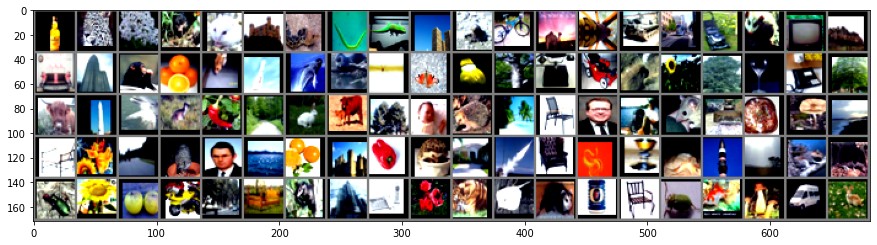

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:100], nrow=20, padding=2))

### Construct InceptionV3 network

In [ ]:
class BasicConv2d(nn.Module):

    def __init__(self, input_channels, output_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [ ]:
class InceptionA(nn.Module):

    def __init__(self, input_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 64, kernel_size=1)

        self.branch5x5 = nn.Sequential(
            BasicConv2d(input_channels, 48, kernel_size=1),
            BasicConv2d(48, 64, kernel_size=5, padding=2)
        )

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, padding=1)
        )

        self.branchpool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, pool_features, kernel_size=3, padding=1)
        )

    def forward(self, x):

        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5(x)

        branch3x3 = self.branch3x3(x)

        branchpool = self.branchpool(x)

        outputs = [branch1x1, branch5x5, branch3x3, branchpool]

        return torch.cat(outputs, 1)

In [ ]:
# Factorization into smaller convolutions
class InceptionB(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = BasicConv2d(input_channels, 384, kernel_size=3, stride=2)

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(input_channels, 64, kernel_size=1),
            BasicConv2d(64, 96, kernel_size=3, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=2)
        )

        self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        branch3x3 = self.branch3x3(x)

        branch3x3stack = self.branch3x3stack(x)

        branchpool = self.branchpool(x)

        outputs = [branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)

In [ ]:
# Factorizing Convolutions with Large Filter Size
class InceptionC(nn.Module):
    def __init__(self, input_channels, channels_7x7):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 192, kernel_size=1)

        c7 = channels_7x7

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch7x7stack = nn.Sequential(
            BasicConv2d(input_channels, c7, kernel_size=1),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))
        )

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1),
        )

    def forward(self, x):

        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7(x)

        branch7x7stack = self.branch7x7stack(x)

        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch7x7, branch7x7stack, branchpool]

        return torch.cat(outputs, 1)

In [ ]:
class InceptionD(nn.Module):

    def __init__(self, input_channels):
        super().__init__()

        self.branch3x3 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 320, kernel_size=3, stride=2)
        )

        self.branch7x7 = nn.Sequential(
            BasicConv2d(input_channels, 192, kernel_size=1),
            BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(192, 192, kernel_size=3, stride=2)
        )

        self.branchpool = nn.AvgPool2d(kernel_size=3, stride=2)

    def forward(self, x):

        branch3x3 = self.branch3x3(x)

        branch7x7 = self.branch7x7(x)

        branchpool = self.branchpool(x)

        outputs = [branch3x3, branch7x7, branchpool]

        return torch.cat(outputs, 1)

In [ ]:
class InceptionE(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.branch1x1 = BasicConv2d(input_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(input_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3stack_1 = BasicConv2d(input_channels, 448, kernel_size=1)
        self.branch3x3stack_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3stack_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3stack_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(input_channels, 192, kernel_size=1)
        )

    def forward(self, x):

        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3)
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3stack = self.branch3x3stack_1(x)
        branch3x3stack = self.branch3x3stack_2(branch3x3stack)
        branch3x3stack = [
            self.branch3x3stack_3a(branch3x3stack),
            self.branch3x3stack_3b(branch3x3stack)
        ]
        branch3x3stack = torch.cat(branch3x3stack, 1)

        branchpool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch3x3stack, branchpool]

        return torch.cat(outputs, 1)

In [ ]:
# Architecture Code: https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/inceptionv3.py
class InceptionV3(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)

        # naive inception module
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)

        # downsample
        self.Mixed_6a = InceptionB(288)

        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        # downsample
        self.Mixed_7a = InceptionD(768)

        self.Mixed_7b = InceptionE(1280)
        self.Mixed_7c = InceptionE(2048)

        # 6*6 feature size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # self.dropout = nn.Dropout2d()
        self.linear = nn.Linear(2048, num_classes)

    def forward(self, x):

        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)

        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)

        x = self.Mixed_6a(x)

        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)

        x = self.Mixed_7a(x)

        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)

        x = self.avgpool(x)
        # x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
model = InceptionV3().to(device)

In [ ]:
print(model)

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (Conv2d_4a_3x3

### Train the model

In [ ]:
epochs = 100
patience = 10
epochs_no_improve = 0
early_stop = False
min_train_loss = np.Inf
learning_rate = 0.001
total_step = len(train_loader)

In [ ]:
accuracy_train, accuracy_test = 0, 0
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
test_predictions, test_labels = [], []

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
for epoch in range(epochs):
    training_loss = 0
    train_correct = 0
    train_total = 0
    _train_loss = 0

    if epochs_no_improve == patience:
      print('Early stopped!')
      break

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        predicted = torch.max(outputs.data, 1)[1].to(device)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        accuracy_train = accuracy_train if accuracy_train > train_correct / train_total else train_correct / train_total

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    else:
        test_loss = 0
        test_correct = 0
        test_total = 0

        # Turn off gradients for validation, saves memory and computations. Test the model
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                test_labels.append(labels)
                images = images.to(device)
                labels = labels.to(device)
                        
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                predicted = torch.max(outputs.data, 1)[1].to(device)
                test_predictions.append(predicted)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
            
            if accuracy_test > test_correct / test_total:
                current_lr = learning_rate * np.asscalar(pow(np.random.rand(1),5))
                # update_lr(optimizer, current_lr)
            else:
                accuracy_test = test_correct / test_total
                        
            model.train()

            _train_loss = training_loss / len(train_loader)
            train_losses.append(_train_loss)
            test_losses.append(test_loss / len(test_loader))

            train_accuracy.append((train_correct / train_total) * 100)
            test_accuracy.append((test_correct / test_total) * 100)

            print("Epoch: {}/{}".format(epoch + 1, epochs), " | Training Loss: {:.3f}".format(train_losses[-1]), " | Training Accuracy: {:.3f}".format(100 * train_correct / train_total), " | Best Training Accuracy: {: .3f}".format(100 * accuracy_train),
                  " | Test Loss: {:.3f}".format(test_losses[-1]), " | Testing Accuracy: {:.3f}".format(100 * test_correct / test_total), " | Best Testing Accuracy: {: .3f}".format(100 * accuracy_test))
      
        if _train_loss < min_train_loss:
          epochs_no_improve = 0
          min_train_loss = _train_loss
        else:
          epochs_no_improve += 1

Epoch: 1/100  | Training Loss: 4.252  | Training Accuracy: 6.428  | Best Training Accuracy:  6.428  | Test Loss: 3.916  | Testing Accuracy: 11.060  | Best Testing Accuracy:  11.060
Epoch: 2/100  | Training Loss: 3.724  | Training Accuracy: 13.240  | Best Training Accuracy:  13.251  | Test Loss: 3.533  | Testing Accuracy: 15.540  | Best Testing Accuracy:  15.540
Epoch: 3/100  | Training Loss: 3.421  | Training Accuracy: 17.782  | Best Training Accuracy:  17.782  | Test Loss: 3.277  | Testing Accuracy: 20.300  | Best Testing Accuracy:  20.300
Epoch: 4/100  | Training Loss: 3.162  | Training Accuracy: 22.422  | Best Training Accuracy:  22.483  | Test Loss: 3.073  | Testing Accuracy: 24.110  | Best Testing Accuracy:  24.110
Epoch: 5/100  | Training Loss: 2.900  | Training Accuracy: 27.302  | Best Training Accuracy:  27.305  | Test Loss: 2.813  | Testing Accuracy: 28.350  | Best Testing Accuracy:  28.350
Epoch: 6/100  | Training Loss: 2.646  | Training Accuracy: 32.572  | Best Training Accu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch: 18/100  | Training Loss: 1.077  | Training Accuracy: 68.956  | Best Training Accuracy:  74.219  | Test Loss: 1.672  | Testing Accuracy: 56.310  | Best Testing Accuracy:  57.150
Epoch: 19/100  | Training Loss: 1.002  | Training Accuracy: 70.814  | Best Training Accuracy:  74.219  | Test Loss: 1.582  | Testing Accuracy: 56.990  | Best Testing Accuracy:  57.150
Epoch: 20/100  | Training Loss: 0.934  | Training Accuracy: 72.836  | Best Training Accuracy:  78.385  | Test Loss: 1.564  | Testing Accuracy: 58.090  | Best Testing Accuracy:  58.090
Epoch: 21/100  | Training Loss: 0.870  | Training Accuracy: 74.448  | Best Training Accuracy:  78.385  | Test Loss: 1.668  | Testing Accuracy: 56.900  | Best Testing Accuracy:  58.090
Epoch: 22/100  | Training Loss: 0.805  | Training Accuracy: 76.326  | Best Training Accuracy:  80.078  | Test Loss: 1.559  | Testing Accuracy: 59.380  | Best Testing Accuracy:  59.380
Epoch: 23/100  | Training Loss: 0.742  | Training Accuracy: 78.150  | Best Train

### Save and load the model

In [ ]:
weight_path ='../weights'
history_path = '../model_history'

In [ ]:
torch.save(model.state_dict(), weight_path + '/InceptionV3_SGD_BatchNormalization.pth')

In [ ]:
all_lists = [train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions]
with open(history_path + '/InceptionV3_SGD_BatchNormalization.pkl', 'wb') as f:
  pickle.dump(all_lists, f)

In [ ]:
model = InceptionV3().to(device)
model.load_state_dict(torch.load(weight_path + '/InceptionV3_SGD_BatchNormalization.pth'))

<All keys matched successfully>

In [ ]:
with open(history_path + '/InceptionV3_SGD_BatchNormalization.pkl', 'rb') as f:
  all_lists = pickle.load(f)
train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions = all_lists

### Model evaluation

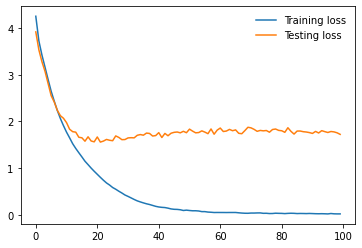

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

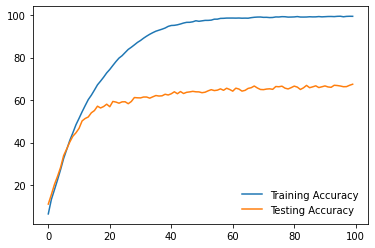

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend(frameon=False)

In [ ]:
confusion_matrix = np.zeros([100, 100], int)
label_list, prediction_list = [], []
for (labels, predictions) in zip(test_labels, test_predictions):
  for (_label, prediction) in zip(labels, predictions):
    label_list.append(_label.item())
    prediction_list.append(prediction.item())
    confusion_matrix[_label.item(), prediction.item()] += 1 

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
confusion_matrix

array([[8027,   36,   76,    0,    0,    0,    3,   76,    0,    3,   36,
           4,    0,    0,    6,    0,    3,    0,   14,    0,    1,    0,
           3,    0,    3,    5,    4,    0,    1,    0,    0,    0,    4,
           0,    2,    3,   34,    0,    0,    6,    0,    3,    0,    2,
           0,   62,    0,    4,    0,    0,    0,   13,    0,  126,   39,
           0,    0,  480,    0,    0,    0,   12,   11,    0,    0,    0,
           0,    0,    0,    0,  118,    0,    0,    0,    0,    0,    0,
           9,    2,    0,    0,    0,   15,  597,    0,    0,    0,    0,
           0,    3,    0,    0,  124,    0,   23,    0,    0,    0,    7,
           0],
       [  13, 7256,    1,    2,    1,    4,   11,    9,    3,   11,   92,
          26,    6,   12,  169,    0,   10,    1,  131,    0,    1,   14,
           2,    2,    3,    1,   37,   32,    6,   41,   18,    1,   33,
          98,  102,    3,   24,    4,    3,   30,   26,   26,    5,    2,
          45,  115,   1

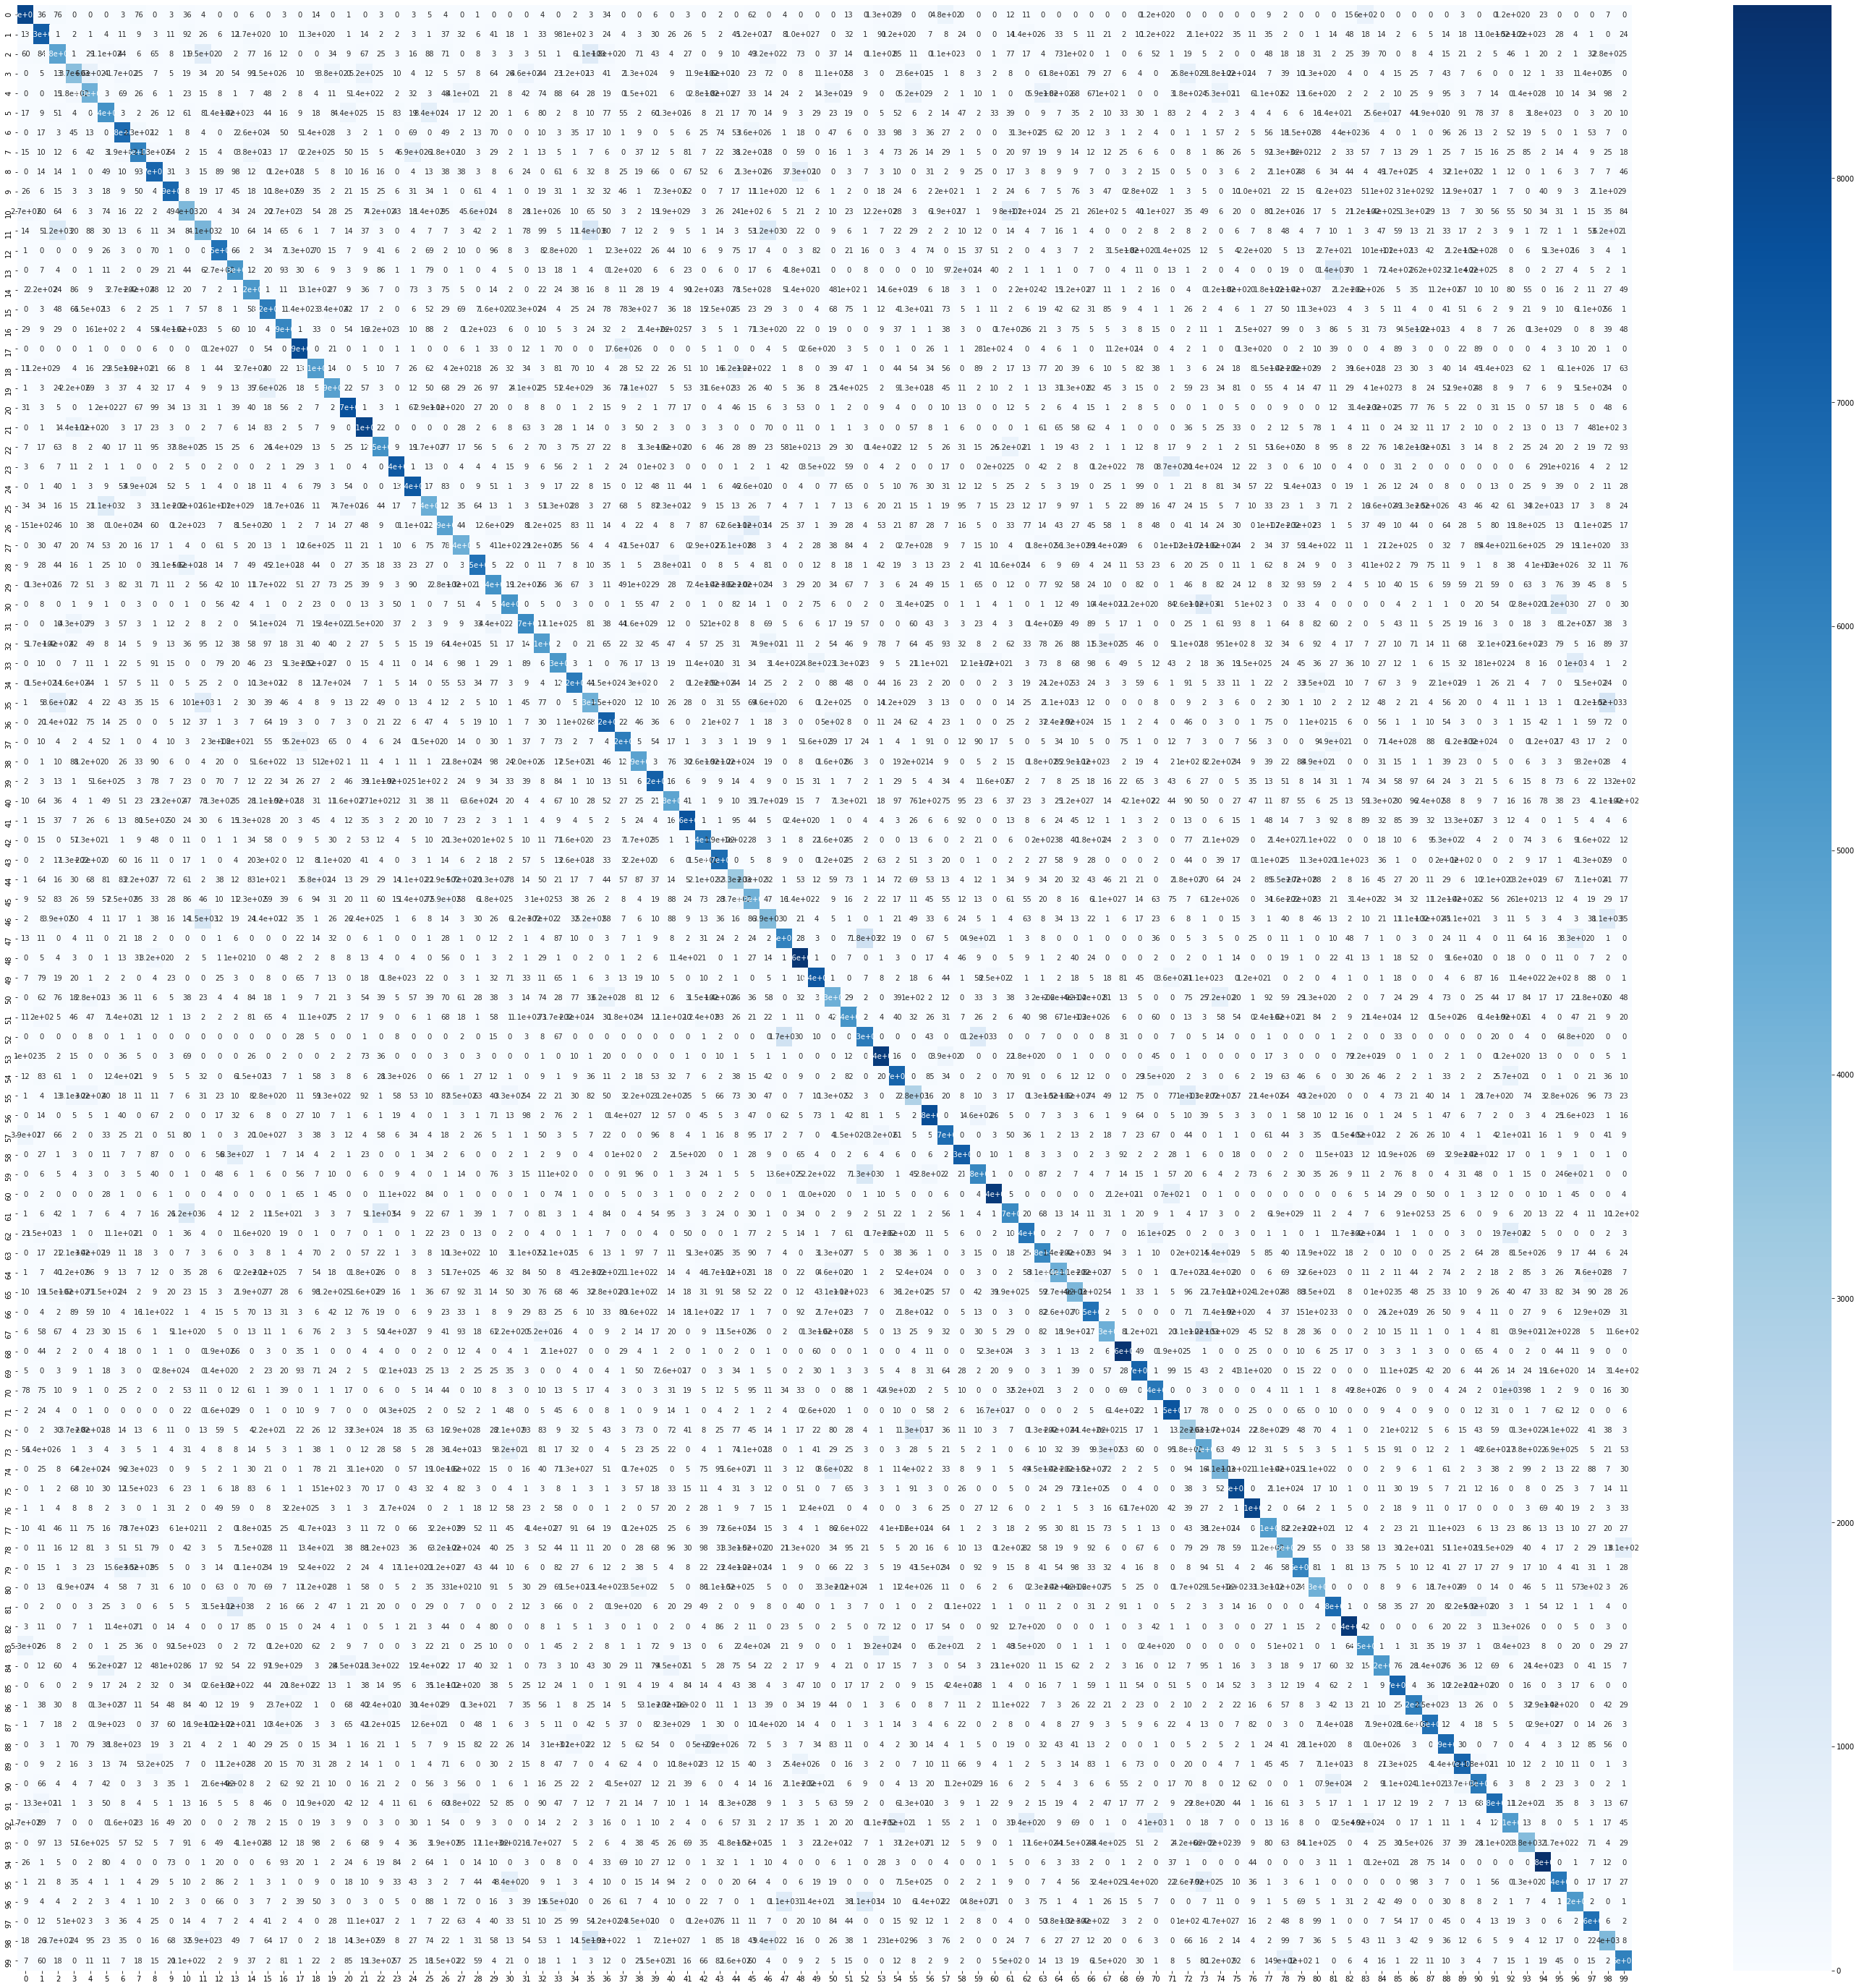

In [ ]:
import seaborn as sns
plt.figure(figsize=(50,50))
sns.heatmap(confusion_matrix, cmap='Blues', annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_list, prediction_list))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80     10000
           1       0.67      0.73      0.70     10000
           2       0.49      0.48      0.49     10000
           3       0.46      0.37      0.41     10000
           4       0.46      0.43      0.45     10000
           5       0.57      0.54      0.56     10000
           6       0.59      0.68      0.63     10000
           7       0.61      0.60      0.60     10000
           8       0.68      0.70      0.69     10000
           9       0.71      0.69      0.70     10000
          10       0.45      0.40      0.42     10000
          11       0.44      0.41      0.42     10000
          12       0.64      0.65      0.65     10000
          13       0.55      0.53      0.54     10000
          14       0.52      0.52      0.52     10000
          15       0.55      0.62      0.58     10000
          16       0.61      0.59      0.60     10000
          17       0.74    

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(label_list, prediction_list, average='weighted'))

(0.5934802591110215, 0.59669, 0.5941129587599399, None)


**Precision and recall from above classification report - 59% (weighted average)**

In [ ]:
max(test_accuracy)

67.49000000000001

**Maximum accuracy - 67.49%**

# References

#### *Dataset*
1. [CIFAR100](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR100)

#### *Code*
1. https://github.com/dipuk0506/SpinalNet
2. https://pytorch.org/docs/stable/nn.html#convolution-layers
3. https://towardsdatascience.com/start-your-cnn-journey-with-pytorch-in-python-6f8364a79801
4. https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/inceptionv3.py

#### *Readings*
1. https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5
2.  https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
3. https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/14
4. http://d2l.ai/chapter_convolutional-neural-networks/index.html
5. http://cs231n.stanford.edu/
6. https://arxiv.org/pdf/1512.00567v1.pdf